In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../utils'))
if module_path not in sys.path:
    sys.path.append(module_path)

from helper_functions import *

In [3]:
## ---- Notebook Variables ---- ##
nb_variables = {'window': 5, 'train_amount': 0.8}

In [4]:
df = pd.read_csv('../../../San_Juan_train.csv', index_col = 0)
df.index = pd.to_datetime(df.index)
df.sort_index(inplace = True)

In [5]:
print('------ Basic Stats about the San Juan Training set ------ \n')
print(f'- Number of rows of the training set: {len(df)} \n')
print(f'- Number of columns of the training set: {len(df.columns)}, where the last on is the label \n')
perc = np.round(100 * df.isna().sum().sum() / (len(df) * len(df.columns)), 2)
print(f'- Percentage of missing values across the entire dataset {perc}% \n')
url = 'https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/82/'
print(f'- Description for all variables can be found here: {url} \n')

------ Basic Stats about the San Juan Training set ------ 

- Number of rows of the training set: 936 

- Number of columns of the training set: 23, where the last on is the label 

- Percentage of missing values across the entire dataset 1.77% 

- Description for all variables can be found here: https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/82/ 



In [6]:
df = fill_values(df, nb_variables['window'])

Filling NA values with the running mean of 4 previous values (window = 5) 

- The amount of NAs was reduced to 0.2% 

- For the next step we will fill the remaining NAs with zeroes 

Filling NA values with 0 

- The amount of NAs was reduced to 0.0% 

- No more NA values left 



In [7]:
## ----- Further Data Engineering ----- ##

<AxesSubplot: >

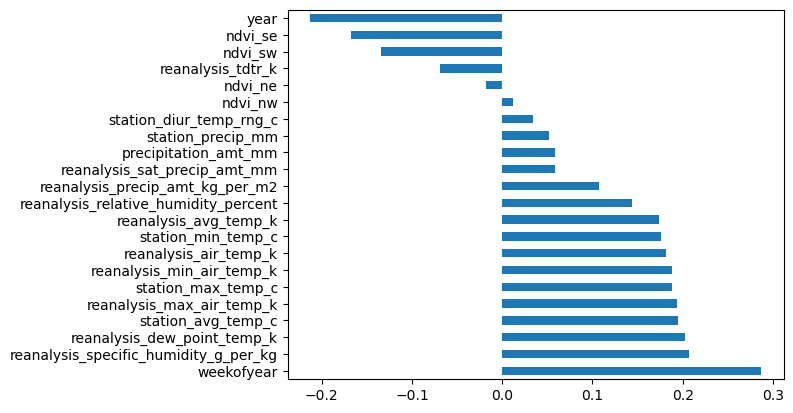

In [8]:
correlations = df.corr()
(correlations
     .total_cases
     .drop('total_cases')
     .sort_values(ascending=False)
     .plot
     .barh())

In [9]:
df.values.shape

(936, 23)

In [11]:
# df.to_csv('df_for_testing.csv')

In [10]:
xin, yout = make_windowed_data(df, nb_variables['window'])

In [111]:
xin.shape

(931, 5, 22)

In [110]:
yout.shape

(931, 1)

In [13]:
train_amount = nb_variables['train_amount']
x_train = xin[:int(train_amount * len(df))]  # df.iloc[:int(train_amount * len(df)), : -1]
x_test = xin[int(train_amount * len(df)):]   # df.iloc[int(train_amount * len(df)):, : -1]

y_train = yout[:int(train_amount * len(df))]  # df.iloc[:int(train_amount * len(df)), -1]
y_test = yout[int(train_amount * len(df)):]   # df.iloc[int(train_amount * len(df)):, -1]

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.data import Dataset
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [91]:
opt = Adam(learning_rate = 5e-5)

model = Sequential()
model.add(SimpleRNN(200, activation = 'tanh', input_shape = (xin.shape[1], xin.shape[2]), 
                    return_sequences = True, use_bias = False))
model.add(BatchNormalization())
model.add(SimpleRNN(200, activation = 'tanh', input_shape = (xin.shape[1], 40), 
                    return_sequences = False, use_bias = False))
model.add(BatchNormalization())
model.add(Dense(50, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(25, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer = opt, loss='mae')

In [92]:
def lr_scheduler(epoch, lr):
    if epoch <= 20:
        return lr
    else:
        return lr * 0.99

In [93]:
# -- Checkpoints -- #
lr_scheduler = LearningRateScheduler(lr_scheduler)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 30, restore_best_weights=True, mode = 'min')
checkpoint = ModelCheckpoint(monitor = 'val_loss', filepath = '../models/sj_lstm.keras', save_best_only = True, 
                             mode = 'min', save_freq = 'epoch')

In [94]:
history = model.fit(x_train, y_train, batch_size = 4, validation_data = (x_test, y_test), epochs=100, verbose=2,
                   use_multiprocessing = True, callbacks = [checkpoint, lr_scheduler])

Epoch 1/100
187/187 - 1s - loss: 36.6173 - val_loss: 24.3935 - lr: 5.0000e-05 - 1s/epoch - 7ms/step
Epoch 2/100
187/187 - 0s - loss: 36.5319 - val_loss: 25.3111 - lr: 5.0000e-05 - 404ms/epoch - 2ms/step
Epoch 3/100
187/187 - 0s - loss: 36.5257 - val_loss: 24.9770 - lr: 5.0000e-05 - 391ms/epoch - 2ms/step
Epoch 4/100
187/187 - 0s - loss: 36.4637 - val_loss: 25.0474 - lr: 5.0000e-05 - 394ms/epoch - 2ms/step
Epoch 5/100
187/187 - 0s - loss: 36.3925 - val_loss: 24.6571 - lr: 5.0000e-05 - 393ms/epoch - 2ms/step
Epoch 6/100
187/187 - 0s - loss: 36.3538 - val_loss: 24.7444 - lr: 5.0000e-05 - 390ms/epoch - 2ms/step
Epoch 7/100
187/187 - 0s - loss: 36.3149 - val_loss: 24.5322 - lr: 5.0000e-05 - 428ms/epoch - 2ms/step
Epoch 8/100
187/187 - 0s - loss: 36.2245 - val_loss: 24.3576 - lr: 5.0000e-05 - 414ms/epoch - 2ms/step
Epoch 9/100
187/187 - 0s - loss: 36.1455 - val_loss: 24.7195 - lr: 5.0000e-05 - 393ms/epoch - 2ms/step
Epoch 10/100
187/187 - 0s - loss: 36.0888 - val_loss: 24.4173 - lr: 5.0000e-

Epoch 80/100
187/187 - 0s - loss: 29.4561 - val_loss: 18.6598 - lr: 2.7634e-05 - 406ms/epoch - 2ms/step
Epoch 81/100
187/187 - 0s - loss: 29.3769 - val_loss: 18.3752 - lr: 2.7358e-05 - 405ms/epoch - 2ms/step
Epoch 82/100
187/187 - 0s - loss: 29.1045 - val_loss: 18.3434 - lr: 2.7084e-05 - 407ms/epoch - 2ms/step
Epoch 83/100
187/187 - 0s - loss: 29.1801 - val_loss: 18.2766 - lr: 2.6813e-05 - 406ms/epoch - 2ms/step
Epoch 84/100
187/187 - 0s - loss: 29.1921 - val_loss: 18.4417 - lr: 2.6545e-05 - 390ms/epoch - 2ms/step
Epoch 85/100
187/187 - 0s - loss: 29.0680 - val_loss: 18.5007 - lr: 2.6280e-05 - 389ms/epoch - 2ms/step
Epoch 86/100
187/187 - 0s - loss: 28.8882 - val_loss: 18.3012 - lr: 2.6017e-05 - 391ms/epoch - 2ms/step
Epoch 87/100
187/187 - 0s - loss: 28.7162 - val_loss: 18.2824 - lr: 2.5757e-05 - 386ms/epoch - 2ms/step
Epoch 88/100
187/187 - 0s - loss: 28.7279 - val_loss: 18.3161 - lr: 2.5499e-05 - 388ms/epoch - 2ms/step
Epoch 89/100
187/187 - 0s - loss: 28.6159 - val_loss: 17.7878 - 

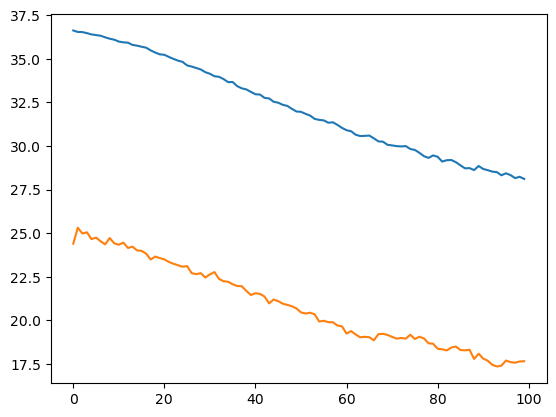

In [95]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [96]:
predictions = model.predict(x_test)
predictions = np.round(predictions).astype('int32')
predictions[predictions < 0] = 0
predictions.shape

6/6 [==============================] - 0s 2ms/step


(183, 1)

Test Dataset MAE: 17.633879781420767


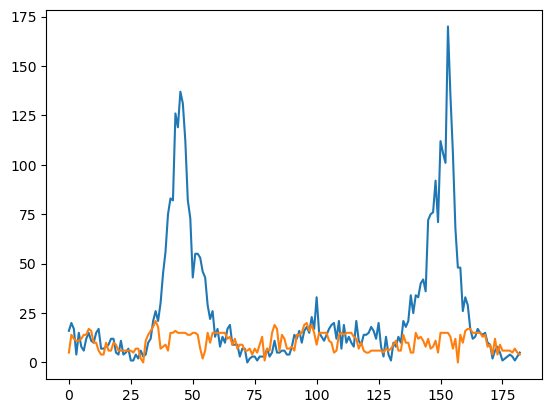

In [98]:
dataset_mae = np.mean(np.abs(predictions - y_test))
print(f'Test Dataset MAE: {dataset_mae}')
plt.plot(y_test)
plt.plot(predictions)
plt.show()

In [99]:
predictions = model.predict(x_train)
predictions = np.round(predictions).astype('int32')
predictions[predictions < 0] = 0
predictions.shape

24/24 [==============================] - 0s 1ms/step


(748, 1)

Test Dataset MAE: 27.717914438502675


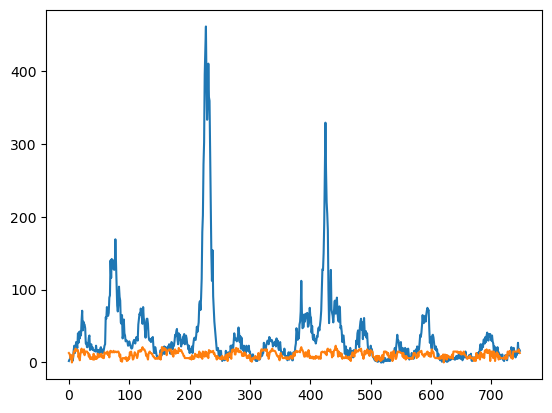

In [100]:
dataset_mae = np.mean(np.abs(predictions - y_train))
print(f'Test Dataset MAE: {dataset_mae}')
plt.plot(y_train)
plt.plot(predictions)
plt.show()